In [1]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import os
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from sklearn.metrics import r2_score

In [8]:
fullpath=[]
Filepath={}
Data = ['SPY','DIA']
for dir, _,filename in os.walk('.'):
    for f in filename:
        fullpath.append(os.path.join(dir,f))
for i in Data:
    for j in fullpath:
        if i in j:
            Filepath.update({i:j})
            break

In [9]:
######################################################################### 
SPY = pd.read_csv(Filepath['SPY'],header = 0,sep=',',index_col=["Date"],parse_dates=['Date'],dayfirst = True)
DIA = pd.read_csv(Filepath['DIA'],header = 0,sep=',',index_col=["Date"],parse_dates=['Date'],dayfirst = True)
spy = SPY[['Open','Close']].rename(columns={'Open':'SPY-Open','Close':'SPY-Close'})
dia = DIA[['Open','Close']].rename(columns = {'Open':'DIA-Open','Close':'DIA-Close'})
df = dia.merge(spy, how = 'inner', left_index = True, right_index =True)

In [10]:
df_values = df.iloc[:,[1,3]].values
dia_close =df_values[:,0]
spy_close =df_values[:,1]

In [11]:
correlation = df['DIA-Close'].corr(df['SPY-Close'])
print('Correlation = ', correlation)

Correlation =  0.9953361309458909


In [13]:
######################################################################### 
#Linear regresion 
slope, intercept , r_value , p_value  ,std_err =stats.linregress(df['SPY-Close'],df['DIA-Close'],)
dia_pred = df['SPY-Close']*slope + intercept
R2 = r2_score(dia_close,dia_pred)
print(R2)

0.990694013566336


Text(0.5, 1.0, 'DIA vs SPY: Price 2007 - 2020')

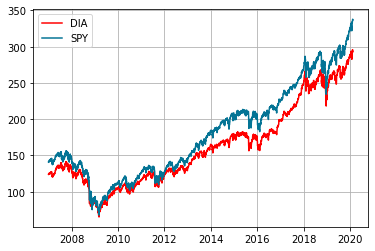

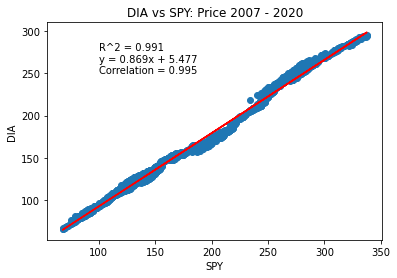

In [14]:
######################################################################### 
#Plotting
plt.figure()
plt.plot(df.index,dia_close,'r',label = 'DIA')
plt.plot(df.index,spy_close,c = 'xkcd:sea blue',label ='SPY')
plt.legend()
plt.grid()
#Plotting
plt.figure()
plt.scatter(df['SPY-Close'],df['DIA-Close'])
plt.plot(df['SPY-Close'],dia_pred,'r')
plt.ylabel('DIA')
plt.xlabel('SPY')
plt.text(100,250,'R^2 = {:.3f}\ny = {:.3f}x + {:.3f}\nCorrelation = {:.3f}'.format(R2,slope,intercept,correlation))
plt.title('DIA vs SPY: Price 2007 - 2020')

## KALMAN FILTER DESIGN

State Evolution: 
Given previous state, we can determine current state, although this exhibit normal distibution due to external uncertainties  
$x_{t}$ = $Fx_{t-1}$ + $w_{t}$ &emsp;$w_{t}$ ~ $N(0,Q)$  
$N(0,Q)$ ~ Process noise  
Covariance matrix: &emsp; $\hat{P}_t$ = $Fx_{t-1}$$F^T$  + $Q$  
  
Measurement:  
$z_{t}$ = $Hx_{t}$ + $v_{t}$  &emsp;$v_{t}$ ~ $N(0,R)$  
$N(0,R)$ ~ Measurement noise  
To get the best estimate, we combine our current prediction with some measurements which also contain Gaussian noise  

Kalman Filter combines the above two pieces of information and gives the optimal state variable as a Gaussian 
distribution N($x_{t|t},P_{t|t}$), where the mean and covariance are  
$x_{t|t}$ = $x_{t|t-1} + K_{t}(z_{t} - Hx_{t|t-1})$  
$P_{t|t}$ = $P_{t|t-1}- KHP_{t|t-1}$  
  
Kalman gain:  &emsp; $K$ = $P_{t|t-1}H^T (HP_{t|t-1} H^T + R)^{-1}$
  
Relationship between the two assests: &emsp; $Dia$ = $B_{t}Spy + v_{t}$ &emsp; $v_{t}$ ~ $N(0,\sigma^2_{v})$  
  
We assume beta is time dependant which has the advantage of capturing the system dynamics.  
  
$B_{t}$ = $x_{t|t-1} + w_{t}$ &emsp; $w_{t}$ ~ $N(0,\sigma^2_{w})$  
  
State equation: &emsp; $B_{t}$ = $x_{t|t-1} + w_{t}$ &emsp; $w_{t}$ ~ $N(0,Q_{t})$  
$Q_{t}$ &emsp;   ~  &emsp;   $\sigma^2_{w}$
  
Measurement: &emsp;$Dia$ = $B_{t}Spy + v_{t}$ &emsp; $v_{t}$ ~ $N(0,\sigma^2_{v})$  
$R_{t}$ &emsp;   ~  &emsp;   $\sigma^2_{v}$  
  
### Algorithm  
`prediction`  
$B_{t}$ = $B_{t|t-1}$  
$\hat{P}_t$ = $P_{t-1} + Q$  
  
`Update`  
$\gamma$  = $\frac{\hat{P}_t}{R_{t}}$  
  
$K_{t}$ =  $\frac{spy}{Spy^{2} + \gamma^{-1}}$  
  
$B_{t}$ = $B_{t|t-1} + K_{t}(Dia - B_{t|t-1}Spy)$  
  
`Update Covariance`
$P_{t}$ = $(1 - K_{t}Spy)\hat{P}_t$

In [15]:
######################################################################### 
# KALMAN FILTER DESIGN
# 
# Initialization
P = np.zeros(spy_close.shape)
Bt =np.zeros(dia_close.shape)   
Bt[0] = 0.9    #State variable
P[0] =1        
Q = 1e-5       #Process noise
R = 0.001      # Measurement noise
for t in range(1,len(spy_close)):
    #|
    # Time Update
    #State equation  Xt = FXt-1 + wt   wt~ N(0,Q), F=1   => Xt = Xt-1
    Pt_minus = P[t-1] + Q        #Error Covariance projection  Pt_minus = FPt-1F' + Q
    
    #Measurement Update
    Signal_to_Noise_ratio = Pt_minus/R      #SNR = Pt|t-1 / R
    K = spy_close[t-1]/(spy_close[t-1]**2  + Signal_to_Noise_ratio)  #k = spy/(spy^2 +   |
    Bt[t] = Bt[t-1] + K*(dia_close[t-1]-Bt[t-1]*spy_close[t-1])
    P[t] = (1 - K*spy_close[t-1])*Pt_minus


In [16]:
############################################
# Rolling regression
Total_days = (df.index[-1]-df.index[1]).days
trading_days = len(df.index)
six_months = int(trading_days/Total_days *180)
# Rolling regression model
model = RollingOLS(endog = df['DIA-Close'] , exog =df['SPY-Close'] ,window = 120 )
rr = model.fit()
######################################################################### 

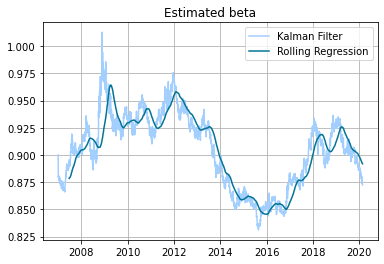

In [21]:
######################################################################### 
#Plotting
pylab.figure()
pylab.plot(df.index,Bt, c = 'xkcd:baby blue',label = 'Kalman Filter')
pylab.plot(df.index,rr.params,c = 'xkcd:sea blue',label= 'Rolling Regression')
pylab.title('Estimated beta')
pylab.legend()
pylab.ylimit = 1.05
pylab.grid()
######################################################################### 


In [22]:
######################################################################### 
# KALMAR SPREAD
values = [0.5,1,2]
kalman_spread= dia_close - Bt*spy_close
# mean_kalman sp= vtt.mean()
kalman_df = pd.DataFrame(kalman_spread,df.index).rename(columns ={0:'spread'})
signal = [ 'buy','sell']
values =[0.5,1,2]
for i in values:   
    for j in signal:
        if j == 'buy':
            kalman_df ['Threshold {} {}'.format(i,j)]=kalman_df['spread'].apply(lambda x: 1 if x>=i else 0)   
        else:
            kalman_df ['Threshold {} {}'.format(i,j)]=kalman_df['spread'].apply(lambda x: -1 if x<=-i else 0) 
    
    kalman_df ['Threshold {} signal'.format(i)]= kalman_df ['Threshold {} buy'.format(i)] +kalman_df ['Threshold {} sell'.format(i)]
kalman_signal = kalman_df[['Threshold 0.5 signal','Threshold 1 signal','Threshold 2 signal']]
######################################################################### 


In [23]:
######################################################################### 
# PAIR TRADING USING KALMAN ESTIMATED BETA

def trading_pair(kalman_signals):
    signal = kalman_signals
    print(signal.value_counts())
    prev_x_qty = 0
    position =0
    trade_size =1
    qty_x = np.zeros(len(Bt))
    qty_y = np.zeros(len(Bt))
        
    for i in range (0,len(Bt)):
        if signal[i] ==1 and position ==0:
            # Buy spread
            prev_x_qty = (Bt[i]*trade_size)
            qty_x[i] = -prev_x_qty
            qty_y[i] = trade_size
            position = 1
        if signal[i] ==-1 and position ==0:
            # Sell spread
            prev_x_qty = (Bt[i]*trade_size)
            qty_x[i] = prev_x_qty
            qty_y[i] = -trade_size
            position =-1
        if signal[i] ==1 and position ==-1:
            # we are short the spread and need to buy
            qty_x[i] = -((Bt[i]*trade_size)+prev_x_qty)
            prev_x_qty = (Bt[i]*trade_size)
            qty_y[i] = 2 * trade_size
            position = 1  
    
        if signal[i] ==-1 and position ==1:
            # we are long the spread and need to sell
            qty_x[i] = (Bt[i]*trade_size)+prev_x_qty
            prev_x_qty = (Bt[i]*trade_size)
            qty_y[i] = -2* trade_size
            position =-1  
    
    qty_x[len(Bt)-1] = -sum(qty_x)
    qty_y[len(Bt)-1] = -sum(qty_y)
    
    return [qty_x,qty_y]

kalman_1 = trading_pair(kalman_signal['Threshold 0.5 signal' ])   #0.5
kalman_2 = trading_pair(kalman_signal['Threshold 1 signal' ])   #1
kalman_3 = trading_pair(kalman_signal['Threshold 2 signal' ])   #2
qty_x1,qty_y1 = kalman_1   #0.5
qty_x2,qty_y2 = kalman_2   #1.0
qty_x3,qty_y3 = kalman_3   #2.0


######################################################################### 

 0    2725
 1     290
-1     289
Name: Threshold 0.5 signal, dtype: int64
 0    3200
 1      53
-1      51
Name: Threshold 1 signal, dtype: int64
 0    3298
-1       4
 1       2
Name: Threshold 2 signal, dtype: int64


In [24]:
######################################################################### 
# COMPUTING EQUITY CURVE
def equity_calc_x(qty):
    cashbuy = np.zeros(len(Bt))
    cashsell= np.zeros(len(Bt))
    position= np.zeros(len(Bt))
    equity= np.zeros(len(Bt))
    for i in range(len(Bt)):
        if np.sign(qty[i]) ==1:
            cashbuy[i] = qty[i]*spy_close[i]
        else:
            cashbuy[i] = 0
        if np.sign(qty[i]) ==-1:
            cashsell[i] = -qty[i]*spy_close[i]
        else:
            cashsell[i] = 0
        position[i] = np.cumsum(qty)[i]
        cumulative_buy = np.cumsum(cashbuy)[i]
        cumulative_sell = np.cumsum(cashsell)[i]
        equity[i] = cumulative_sell - cumulative_buy + position[i] * spy_close[i]
    return equity

def equity_calc_y(qty):
    cashbuy = np.zeros(len(Bt))
    cashsell= np.zeros(len(Bt))
    position= np.zeros(len(Bt))
    equity= np.zeros(len(Bt))
    for i in range(len(Bt)):
        if np.sign(qty[i]) ==1:
            cashbuy[i] = qty[i]*dia_close[i]
        else:
            cashbuy[i] = 0
        if np.sign(qty[i]) ==-1:
            cashsell[i] = -qty[i]*dia_close[i]
        else:
            cashsell[i] = 0
        position[i] = np.cumsum(qty)[i]
        cumulative_buy = np.cumsum(cashbuy)[i]
        cumulative_sell = np.cumsum(cashsell)[i]
        equity[i] = cumulative_sell - cumulative_buy + position[i] * dia_close[i]
    return equity
Equity_1= equity_calc_x(qty_x1)+equity_calc_y(qty_y1) 
Equity_2 = equity_calc_x(qty_x2)+equity_calc_y(qty_y2) 
Equity_3 = equity_calc_x(qty_x3)+equity_calc_y(qty_y3) 

#########################################################################

In [25]:
# DRAWDOWN COMPUTATION  
def drawdown(x):
    return np.maximum.accumulate(x)-x
dd_1 =drawdown(Equity_1)
dd_2 =drawdown(Equity_2)
dd_3 =drawdown(Equity_3)
print('K = 0.5, Max_drawdown  = {}'.format (max(dd_1)))
print('K = 1, Max_drawdown  = {}'.format (max(dd_2)))
print('K = 2, Max_drawdown  = {}'.format (max(dd_3)))

Total_year = df.index[-1].year-df.index[1].year


#########################################################################  

K = 0.5, Max_drawdown  = 36.212344083517664
K = 1, Max_drawdown  = 27.639905847116566
K = 2, Max_drawdown  = 15.47468125206862


In [26]:
#########################################################################    
# CAGR COMPUTATION 

CAGR_1 =( max(dd_1)**(1/Total_year)-1) * 100
CAGR_2 = (max(dd_2)**(1/Total_year)-1 ) * 100
CAGR_3 =( max(dd_3)**(1/Total_year)-1) * 100

print('K = 0.5, CAGR  = {}'.format (CAGR_1))
print('K = 1, CAGR  = {}'.format (CAGR_2))
print('K = 2, CAGR  = {}'.format (CAGR_3))

######################################################################### 

K = 0.5, CAGR  = 31.798979957553275
K = 1, CAGR  = 29.088462334729037
K = 2, CAGR  = 23.455192922491676


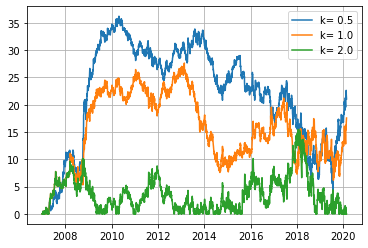

In [37]:
#########################################################################    
# PLOTTING DD
plt.figure()
plt.plot(df.index,dd_1, label ='k= 0.5')
plt.plot(df.index,dd_2,label ='k= 1.0')
plt.plot(df.index,dd_3,label ='k= 2.0')
plt.show
plt.legend()
plt.grid()

#########################################################################  

In [28]:
#########################################################################  
# SHARP RATIO
def sharp_Ratio(x,rf):
    sharpe = (x.mean()- rf)/(x.std())
    return sharpe
sr1 = np.diff(dd_1)/dd_1[:len(dd_1)-1]
sr1= sr1[~np.isinf(sr1) & ~np.isnan(sr1)]
sr2 = np.diff(dd_2)/dd_2[:len(dd_2)-1]
sr2= sr2[~np.isinf(sr2) & ~np.isnan(sr2)]
sr3 = np.diff(dd_3)/dd_3[:len(dd_3)-1]
sr3= sr3[~np.isinf(sr3) & ~np.isnan(sr3)]

print('K = 0.5, SR  = {}'.format (sharp_Ratio(sr1,0)*trading_days**0.5))
print('K = 1, SR = {}'.format (sharp_Ratio(sr2,0)*trading_days**0.5))
print('K = 2, SR = {}'.format (sharp_Ratio(sr3,0)*trading_days**0.5))

K = 0.5, SR  = 0.14769335545626236
K = 1, SR = 0.02625977099675188
K = 2, SR = 1.6547132242981046


<ipython-input-28-c3e4643fa0c4>:6: RuntimeWarning: divide by zero encountered in true_divide
  sr1 = np.diff(dd_1)/dd_1[:len(dd_1)-1]
<ipython-input-28-c3e4643fa0c4>:6: RuntimeWarning: invalid value encountered in true_divide
  sr1 = np.diff(dd_1)/dd_1[:len(dd_1)-1]
<ipython-input-28-c3e4643fa0c4>:8: RuntimeWarning: divide by zero encountered in true_divide
  sr2 = np.diff(dd_2)/dd_2[:len(dd_2)-1]
<ipython-input-28-c3e4643fa0c4>:8: RuntimeWarning: invalid value encountered in true_divide
  sr2 = np.diff(dd_2)/dd_2[:len(dd_2)-1]
<ipython-input-28-c3e4643fa0c4>:10: RuntimeWarning: divide by zero encountered in true_divide
  sr3 = np.diff(dd_3)/dd_3[:len(dd_3)-1]
<ipython-input-28-c3e4643fa0c4>:10: RuntimeWarning: invalid value encountered in true_divide
  sr3 = np.diff(dd_3)/dd_3[:len(dd_3)-1]


In [29]:
######################################################################### 
# PAIR TRADING USING ROLLING REGRESSION ESTIMATED BETA

# ROLLING REGRESSION SPREAD
rolling_regression_df = rr.params
rolling_regression_df.rename(columns={'SPY-Close':'beta'},inplace =True)
beta =rolling_regression_df['beta']
rolling_regression_df['spread'] = dia_close - spy_close * rolling_regression_df['beta']
signal = [ 'buy','sell']
values =[0.5,1,2]
for i in values:   
    for j in signal:
        if j == 'buy':
            rolling_regression_df['Threshold {} {}'.format(i,j)]=rolling_regression_df['spread'].apply(lambda x: 1 if x>=i else 0)   
        else:
            rolling_regression_df['Threshold {} {}'.format(i,j)]=rolling_regression_df['spread'].apply(lambda x: -1 if x<=-i else 0) 
    
    rolling_regression_df ['Threshold {} signal'.format(i)]= rolling_regression_df['Threshold {} buy'.format(i)] + rolling_regression_df['Threshold {} sell'.format(i)]
Rolling_signal = rolling_regression_df[['Threshold 0.5 signal','Threshold 1 signal','Threshold 2 signal']]
######################################################################### 

In [30]:
######################################################################### 
# PAIR TRADING 

def trading_pair_regress(Rolling_signals):
    signal_= Rolling_signals
    print(signal_.value_counts())
    prev_x_qty_ = 0
    position_ =0
    trade_size_ =1
    qty_x_ = np.zeros(len(signal_))
    qty_y_ = np.zeros(len(signal_))
        
    for i in range (0,len(signal_)):
        if signal_[i] ==1 and position_ ==0:
            # Buy spread
            prev_x_qty_ = (beta[i]*trade_size_)
            qty_x_[i] = -prev_x_qty_
            qty_y_[i] = trade_size_
            position_ = 1
        if signal_[i] ==-1 and position_ ==0:
            # Sell spread
            prev_x_qty_ = (beta[i]*trade_size_)
            qty_x_[i] = prev_x_qty_
            qty_y_[i] = -trade_size_
            position_ =-1
        if signal_[i] ==1 and position_ ==-1:
            # we are short the spread and need to buy
            qty_x_[i] = -((beta[i]*trade_size_)+prev_x_qty_)
            prev_x_qty_ = (beta[i]*trade_size_)
            qty_y_[i] = 2 * trade_size_
            position_ = 1  
    
        if signal_[i] ==-1 and position_ ==1:
            # we are long the spread and need to sell
            qty_x_[i] = (beta[i]*trade_size_)+prev_x_qty_
            prev_x_qty_ = (beta[i]*trade_size_)
            qty_y_[i] = -2* trade_size_
            position_ =-1  
    
    qty_x_[len(signal_)-1] = -sum(qty_x_)
    qty_y_[len(signal_)-1] = -sum(qty_y_)
    
    return [qty_x_,qty_y_]

Rolling_1 = trading_pair_regress(Rolling_signal['Threshold 0.5 signal' ])   #0.5
Rolling_2 = trading_pair_regress(Rolling_signal['Threshold 1 signal' ])   #1
Rolling_3 = trading_pair_regress(Rolling_signal['Threshold 2 signal' ])   #2
qty_x1_r,qty_y1_r = Rolling_1   #0.5
qty_x2_r,qty_y2_r = Rolling_2   #1.0
qty_x3_r,qty_y3_r = Rolling_3   #2.0

#########################################################################

-1    1403
 1    1233
 0     668
Name: Threshold 0.5 signal, dtype: int64
 0    1189
-1    1127
 1     988
Name: Threshold 1 signal, dtype: int64
 0    2111
-1     639
 1     554
Name: Threshold 2 signal, dtype: int64


In [31]:
######################################################################### 
# COMPUTING EQUITY CURVE
def equity_calc_xr(qty):
    cashbuy = np.zeros(len(beta))
    cashsell= np.zeros(len(beta))
    position= np.zeros(len(beta))
    equity= np.zeros(len(beta))
    for i in range(len(beta)):
        if np.sign(qty[i]) ==1:
            cashbuy[i] = qty[i]*spy_close[i]
        else:
            cashbuy[i] = 0
        if np.sign(qty[i]) ==-1:
            cashsell[i] = -qty[i]*spy_close[i]
        else:
            cashsell[i] = 0
        position[i] = np.cumsum(qty)[i]
        cumulative_buy = np.cumsum(cashbuy)[i]
        cumulative_sell = np.cumsum(cashsell)[i]
        equity[i] = cumulative_sell - cumulative_buy + position[i] * spy_close[i]
    return equity

def equity_calc_yr(qty):
    cashbuy = np.zeros(len(beta))
    cashsell= np.zeros(len(beta))
    position= np.zeros(len(beta))
    equity= np.zeros(len(beta))
    for i in range(len(beta)):
        if np.sign(qty[i]) ==1:
            cashbuy[i] = qty[i]*dia_close[i]
        else:
            cashbuy[i] = 0
        if np.sign(qty[i]) ==-1:
            cashsell[i] = -qty[i]*dia_close[i]
        else:
            cashsell[i] = 0
        position[i] = np.cumsum(qty)[i]
        cumulative_buy = np.cumsum(cashbuy)[i]
        cumulative_sell = np.cumsum(cashsell)[i]
        equity[i] = cumulative_sell - cumulative_buy + position[i] * dia_close[i]
    return equity
rol_equity_1= equity_calc_xr(qty_x1_r)+equity_calc_yr(qty_y1_r) 
rol_equity_2 = equity_calc_xr(qty_x2_r)+equity_calc_yr(qty_y2_r) 
rol_equity_3 = equity_calc_xr(qty_x3_r)+equity_calc_yr(qty_y3_r) 

In [32]:
#########################################################################    
# DRAWDOWN COMPUTATION  
dd_1_r =drawdown(rol_equity_1)
dd_2_r=drawdown(rol_equity_2)
dd_3_r =drawdown(rol_equity_3)
print('K = 0.5, Max_drawdown  = {}'.format (max(dd_1_r)))
print('K = 1, Max_drawdown  = {}'.format (max(dd_2_r)))
print('K = 2, Max_drawdown  = {}'.format (max(dd_3_r)))

Total_year = df.index[-1].year-df.index[1].year


#########################################################################   

K = 0.5, Max_drawdown  = 17.461090281788472
K = 1, Max_drawdown  = 16.471229490951373
K = 2, Max_drawdown  = 28.61647507778477


In [33]:
#########################################################################    
# CAGR COMPUTATION 

CAGR_1_r =( max(dd_1_r)**(1/Total_year)-1) * 100
CAGR_2_r = (max(dd_2_r)**(1/Total_year)-1 ) * 100
CAGR_3_r=( max(dd_3_r)**(1/Total_year)-1) * 100

print('K = 0.5, CAGR  = {}'.format (CAGR_1_r))
print('K = 1, CAGR  = {}'.format (CAGR_2_r))
print('K = 2, CAGR  = {}'.format (CAGR_3_r))

#########################################################################    

K = 0.5, CAGR  = 24.607433361815588
K = 1, CAGR  = 24.04929747618936
K = 2, CAGR  = 29.433708656533696


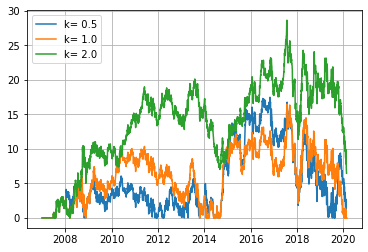

In [36]:
#########################################################################    
# PLOTTING DD
plt.figure()
plt.plot(df.index,dd_1_r, label ='k= 0.5')
plt.plot(df.index,dd_2_r,label ='k= 1.0')
plt.plot(df.index,dd_3_r,label ='k= 2.0')
plt.show
plt.legend()
plt.grid()

In [35]:
#########################################################################   
# SHARP RATIO


def sharp_Ratio(x,rf):
    sharpe = (x.mean()- rf)/(x.std())
    return sharpe
sr1_ = np.diff(dd_1_r)/dd_1_r[:len(dd_1_r)-1]
sr1_= sr1_[~np.isinf(sr1_) & ~np.isnan(sr1_)]
sr2_ = np.diff(dd_2_r)/dd_2_r[:len(dd_2_r)-1]
sr2_= sr2_[~np.isinf(sr2_) & ~np.isnan(sr2_)]
sr3_ = np.diff(dd_3_r)/dd_3_r[:len(dd_3_r)-1]
sr3_= sr3_[~np.isinf(sr3_) & ~np.isnan(sr3_)]

print('K = 0.5, SR  = {}'.format (sharp_Ratio(sr1_,0)*trading_days**0.5))
print('K = 1, SR = {}'.format (sharp_Ratio(sr2_,0)*trading_days**0.5))
print('K = 2, SR = {}'.format (sharp_Ratio(sr3_,0)*trading_days**0.5))

K = 0.5, SR  = 2.686882313520297
K = 1, SR = 1.3015700177616787
K = 2, SR = 1.6400266696760777


<ipython-input-35-07649c47ab83>:8: RuntimeWarning: divide by zero encountered in true_divide
  sr1_ = np.diff(dd_1_r)/dd_1_r[:len(dd_1_r)-1]
<ipython-input-35-07649c47ab83>:8: RuntimeWarning: invalid value encountered in true_divide
  sr1_ = np.diff(dd_1_r)/dd_1_r[:len(dd_1_r)-1]
<ipython-input-35-07649c47ab83>:10: RuntimeWarning: divide by zero encountered in true_divide
  sr2_ = np.diff(dd_2_r)/dd_2_r[:len(dd_2_r)-1]
<ipython-input-35-07649c47ab83>:10: RuntimeWarning: invalid value encountered in true_divide
  sr2_ = np.diff(dd_2_r)/dd_2_r[:len(dd_2_r)-1]
<ipython-input-35-07649c47ab83>:12: RuntimeWarning: divide by zero encountered in true_divide
  sr3_ = np.diff(dd_3_r)/dd_3_r[:len(dd_3_r)-1]
<ipython-input-35-07649c47ab83>:12: RuntimeWarning: invalid value encountered in true_divide
  sr3_ = np.diff(dd_3_r)/dd_3_r[:len(dd_3_r)-1]
